# Developing code to reconstruct the image with SART.
Umberto's solution from HW2:

    function [m, res_norm, rmse] = sart(A, m0, d, max_iter, mtrue)
        w = 1.;
        M = spdiags( 1./sum(A,2), 0, length(d), length(d));
        B = spdiags( 1./sum(A,1)', 0, length(m0), length(m0));
        [m, res_norm, rmse] = gli(A, m0, d, w, B, M, max_iter, mtrue);
    end

    %% Implementation of generalized Landweber Iteration
    function [m, res_norm, rmse] = gli(A, m0, d, w, B, M, max_iter, mtrue)
        m = m0;
        res_norm = zeros(max_iter,1);
        rmse = zeros(max_iter,1);
        if isempty(B)
            B = speye(length(m));
        end

        r = d;
        for j=1:max_iter
            m = m + w*B*A'*M*r;
            r = d - A*m;
            res_norm(j) = norm(r);
            rmse(j)     = norm(mtrue-m);
        end
    end

In [20]:
import os
import sys

import astra
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io as scio
from scipy import sparse

In [129]:
proj_data = scio.loadmat(os.path.join("data", "project_data.mat"))
A90 = scio.loadmat(os.path.join("data", "A90.mat"))
# A90 = scio.loadmat(os.path.join("data", "A.mat"))
A90 = A90["A"].tocsr()
sino90 = scio.loadmat(os.path.join("data", "Sinogram90.mat"))
sino90 = sino90["sinogram90"]
# sino90 = proj_data["sinogram"]
sino90_flat = sino90.flatten(order="F")

In [137]:
n_pixels = np.product(proj_data["imgref"].shape)
model_init = np.zeros(n_pixels)
max_iter = 1000
omega = 1.0

# V matrix: sum the rows and use to create a sparse diagonal matrix (B in Umberto's code)
V = sparse.spdiags((1 / A90.sum(axis=0)), 0, len(model_init), len(model_init))
# W matrix: sum the columns and use to create a sparse diagonal matrix (M in Umberto's code)
W = sparse.spdiags((1 / A90.sum(axis=1)).T, 0, len(sino90_flat), len(sino90_flat))

# SART method
model = model_init
residual = sino90_flat

residual_norm = np.zeros(max_iter)
# Precompute the constant term, call it X
X = omega * V * A90.T * W
for i in range(max_iter):
    model = model + X * residual
    model_mat = model.reshape((256, 256))
    residual = sino90_flat - A90 * model
    residual_norm[i] = np.linalg.norm(residual)
    if (i + 1) % 50 == 0:
        print(f"Completed {i+1} iterations.")
#         fig, ax = plt.subplots()
#         ax.imshow(model_mat, cmap="Greys")
#         ax.set_title(i)

Completed 50 iterations.
Completed 100 iterations.
Completed 150 iterations.
Completed 200 iterations.
Completed 250 iterations.
Completed 300 iterations.
Completed 350 iterations.
Completed 400 iterations.
Completed 450 iterations.
Completed 500 iterations.
Completed 550 iterations.
Completed 600 iterations.
Completed 650 iterations.
Completed 700 iterations.
Completed 750 iterations.
Completed 800 iterations.
Completed 850 iterations.
Completed 900 iterations.
Completed 950 iterations.
Completed 1000 iterations.


Text(0, 0.5, 'Norm of residual')

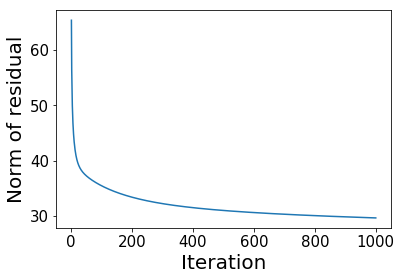

In [138]:
fig, ax = plt.subplots()
ax.plot(np.arange(max_iter) + 1, residual_norm)
ax.set_xlabel("Iteration")
ax.set_ylabel("Norm of residual")

Text(0.5, 1.0, 'Reconstruction')

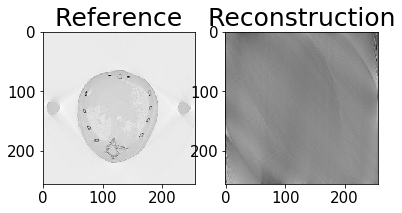

In [139]:
model_mat = model.reshape(proj_data["imgref"].shape, order="F")
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(proj_data["imgref"], cmap="Greys")
ax[0].set_title("Reference")
ax[1].imshow(model_mat, cmap="Greys")
ax[1].set_title("Reconstruction")

Text(0.5, 1.0, 'Reconstruction')

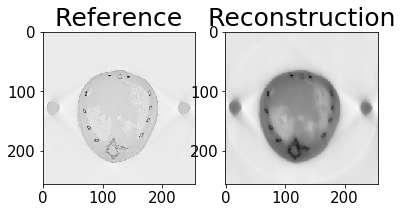

In [140]:
# Repeat for full data
A90 = scio.loadmat(os.path.join("data", "A.mat"))
A90 = A90["A"].tocsr()
sino90 = proj_data["sinogram"]
sino90_flat = sino90.flatten(order="F")

n_pixels = np.product(proj_data["imgref"].shape)
model_init = np.zeros(n_pixels)
max_iter = 25
omega = 1.0

# V matrix: sum the rows and use to create a sparse diagonal matrix (B in Umberto's code)
V = sparse.spdiags((1 / A90.sum(axis=0)), 0, len(model_init), len(model_init))
# W matrix: sum the columns and use to create a sparse diagonal matrix (M in Umberto's code)
W = sparse.spdiags((1 / A90.sum(axis=1)).T, 0, len(sino90_flat), len(sino90_flat))

# SART method
model = model_init
residual = sino90_flat

residual_norm = np.zeros(max_iter)
# Precompute the constant term, call it X
X = omega * V * A90.T * W
for i in range(max_iter):
    model = model + X * residual
    model_mat = model.reshape((256, 256))
    residual = sino90_flat - A90 * model
    residual_norm[i] = np.linalg.norm(residual)
    if (i + 1) % 50 == 0:
        print(f"Completed {i+1} iterations.")
#         fig, ax = plt.subplots()
#         ax.imshow(model_mat, cmap="Greys")
#         ax.set_title(i)

model_mat = model.reshape(proj_data["imgref"].shape, order="F")
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(proj_data["imgref"], cmap="Greys")
ax[0].set_title("Reference")
ax[1].imshow(model_mat, cmap="Greys")
ax[1].set_title("Reconstruction")